In [1]:
from __future__ import division

import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import decorator

from itertools import permutations

%matplotlib inline

##### 2-Opt Algorithm

In our first two attempts at the Traveling Salesman Problem, we employed the nearest neighbor algorith, a class of greedy algorithms in which we pick a starting point and sequentially choose cities based on their distance to the current city. This approach had the benefit of allowing us to tackle very large sets of cities (1000 city set in under 1 second), but was limited by the fact that local optimality (choosing the closest city to the current one) did not necessarily result in the globally optimal solution. 

One reason for this is we were choosing our starting point at random, and we found that choosing the right starting point made an impact on the effectiveness of the solution uncovered using nearest neighbors. In order to work around this limitation, we built a better nearest neighbor solution that re-ran the algorithm N times for N cities, alternating starting points until we found the most effective solution.

Even with our *better_nn* function, however, there were still cases where the algorithm missed the optimal global solution by maximizing for the best local solution. Consider the following case where we ran *better_nn* on a set of 25 cities:

<img src="https://github.com/chughtaimh/Traveling-Salesman-Algorithm-Problem/blob/master/Better%20NN%2025%20Cities2.jpg?raw=true", width=450, height=300></img>

In the above plot, our nearest neighbor algorithm chose at least two non-optimal solutions, which manifested themselves as the crossed $\overline{20:21}$ and $\overline{18:19}$ lines, as well as the crossed $\overline{13:14}$ and $\overline{15:16}$ lines.

In our next iteration, we'll aim to correct non-optimal choices made by our nearest neighbor algorithm which result in crossed lines by using a <a href="https://en.wikipedia.org/wiki/2-opt">2-Opt</a> algorithm. The 2-Opt algorithm essentially seeks to find crossed lines that occur as a result of poor optimization choices and uncrosses them by switching their order. (The link to Wikipedia has a great example.)

In this case, the 2-Opt algorithm would identify a non-otimal decision at lines $\overline{20:21}$ and $\overline{18:19}$, remove both of those lines from our tour, and replace them with the more optimal $\overline{21:19}$ and $\overline{20:18}$ lines.

<img src="https://github.com/chughtaimh/Traveling-Salesman-Algorithm-Problem/blob/master/Better%20NN%2025%20Fixed.jpg?raw=true", width=450, height=400>

In order to accomplish this, though, we'll need to figure out a way to identify if two lines are crossed.

In general, we can find the intersection between two lines by setting their equations equal to one another:

y = m$_1$x + b$_1$

y = m$_2$x + b$_2$

m$_1$x + b$_1$ = m$_2$x + b$_2$

m$_1$x = m$_2$x + b$_2$ - b$_2$

(m$_1$ - m$_2$)x = b$_2$ - b$_2$

x = (b$_2$ - b$_2$) $\div$ (m$_1$ - m$_2$)

In [2]:
def slope(p1, p2):
    """Returns slope of a line connecting two points."""
    try:
        return (Y(p2) - Y(p1)) / (X(p2) - X(p1))
    except ZeroDivisionError:
        return 0 # Not technically correct, but useful for now

def y_intercept(slope, point):
    """Given a point and a slope, returns the y-intercept of the line."""
    return Y(point) - (slope * X(point))

Line segments are slightly more interesting, however, since they can finite and only intersect if the potential intersection lies on both segments. 

In [3]:
def intersect(A, B, width=600, height=400):
    """Returns true if lines :A: and :B: intercept within the plot area."""
    m1, m2 = slope(*A), slope(*B)
    b1, b2 = y_intercept(m1, A[0]), y_intercept(m2, B[0])
    
    if m1 == m2 and b1 != b2: return False #Parallel, never meet
    elif m1 == m2: return True #Parallel, colinear
    else:
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
        return on_line(A, complex(x, y)) and on_line(B, complex(x, y))
    
def on_line(line, point):
    """Returns True if a point exists on a line segment"""
    xs = round(X(point),8) > min(map(X, line)) and round(X(point), 8) < max(map(X, line))
    ys = round(Y(point), 8) > min(map(Y, line)) and round(Y(point), 8) < max(map(Y, line))
    return xs and ys

Lets also recreate our plotting methods.

In [4]:
def make_cities(n, max_height=600, max_width=400, seed=1000):
    """Returns list of n cities (points) within a *max_height* by *max_width* 
    grid."""
    random.seed(n * seed)
    return [complex(random.randrange(max_height), random.randrange(max_width))
            for i in range(n)]


def plot_route(route, style='gs-'):
    """Given a route, plots the route end to end."""
    plot_lines(list(route) + [route[0]], style)
    
    
def plot_lines(points, style='gs-', display=True):
    """Given a set of points, plots the points."""
    plt.plot([X(p) for p in points], [Y(p) for p in points], style)
    plt.axis('scaled'); plt.axis('off')
    if display: print('Route distance:', route_length(points))
        
        
def X(point): return point.real


def Y(point): return point.imag


def distance(A, B):
    """Returns the distance between two points."""
    return abs(A - B)


def route_length(route):
    """Returns the total length of a route."""
    return sum(distance(route[i], route[i-1]) for i, n in enumerate(route))


def better_nn(n_cities=0, cities=[], seed=1000):
    """Creates a set of *n* cities. Choose each city one by one and runs the
    nearest neighbor algorithm with that city as the start. In the end, returns
    the tour with the shortest *tour_length*."""
    cities = cities[::] or make_cities(n_cities)
    routes = [altered_nn(city, cities) for city in cities]
    
    return min(routes, key=route_length)
    

def altered_nn(city, cities):
    """Takes a start city and a list of cities, and returns a route implementing
    the NN algorithm"""
    cities = cities[::] # Make copy of cities
    start = city
    route = [start]
    cities.remove(start)
    
    for number_of_cities in range(len(cities)):
        closest = closest_city(route[-1], cities)
        route.append(closest)
        cities.remove(closest)
    
    return route


def closest_city(city, cities): 
    """Returns the closest city in a set of cities."""
    return min(cities, key=lambda x: distance(x, city))


def labeled_plot(route):
    """Given a route, plots the route end to end."""
    for i, city in enumerate(route):
        plt.text(X(city), Y(city), '  {}'.format(str(i)))
    plot_lines(list(route)+[route[0]])

Let's test our new *intersect* method with the lines we know intersect from our 25 cities set.

In [5]:
c25 = better_nn(25)

In [6]:
intersect(c25[20:22], c25[18:20])

True

Let's also make sure it doesn't flag lines we know don't intersect.

In [7]:
intersect(c25[20:22], c25[6:8])

False

Great! Now let's create our 2-opt algorithm.

In [8]:
def two_opt(n, t=10,seed=1000):
    """Creates a set of cities and finds a solution to TSP by first using
    a greedy algorithm. Then identifies if there are any crossed lines in
    the solution set. If there are, it removes those lines from the
    solution and attempts to replace them with non-crossed lines."""
    cities = better_nn(0, make_cities(n), seed)[::]
    attempts = 0
    while crossed(cities):
        new_cities = uncross(cities)
        if new_cities == cities:
            attempts += 1
        else: attempts = 0
        cities = new_cities
        if attempts >= t: break
    return cities

Here is the approach I took to uncross segments using the 2-opt algorithm:

1. Find a solution for the cities set using the *better_nn* algorithm
2. Find any crossed line segments
3. For each crossed line segment pair, re-order the points in the pair to uncross.
4. Keep the solution if it results in a shorter *route_length*, otherwise revert back to the original
5. Repeat steps 2-4 until all segments are uncrossed, or until we have run the algorithm *t* times consecutively without returning a more optimal solution

In [9]:
def all_segments(cities):
    return [[cities[i], cities[i-1]]
            for i, _ in enumerate(cities)]


def crossed(route):
    """Returns the pairs of segments in a route that are crossed."""
    segments = all_segments(route)
    return [(s1, s2)
            for s1 in segments
            for s2 in segments
            if id(s1) > id(s2)
            and intersect(s1, s2)]


def switch_order(cities, seg1, seg2):
    """Swaps the order of the two segments in a set of cities, replacing
    the second point in :seg1: with the first point in :seg2:."""
    c = cities[::]
    p1, p2, p3, p4 = map(c.index, [seg1[0], seg1[1], seg2[0], seg2[1]])
    c[p2], c[p3] = c[p3], c[p2]
    return c


def uncross(route):
    """Takes a route of cities and iteratively uncrosses each set of
    crossed lines if the resulting set has a shorter :route_length:"""
    crossed_lines = [lines for lines in crossed(route)]
    for lines in crossed_lines:
        test = switch_order(route[::], *lines)
        route = min([test, route], key=route_length)
    return route

('Route distance:', 2425.8539208384977)
CPU times: user 128 ms, sys: 7.66 ms, total: 136 ms
Wall time: 132 ms


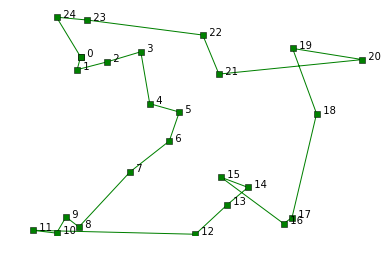

In [10]:
%time labeled_plot(better_nn(0, make_cities(25)))

('Route distance:', 2251.461504001219)
CPU times: user 168 ms, sys: 35.5 ms, total: 204 ms
Wall time: 179 ms


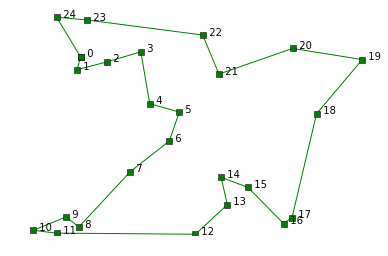

In [11]:
%time labeled_plot(two_opt(25))

Much better! We've now uncrossed the two areas (line segments ($\overline{13-14}$ - $\overline{15-16}$ and $\overline{18-19}$ - $\overline{20-21}$ we identified earlier as having crossed lines.

Let's test the overall improvement of the 2-opt algorithm over our *better_nn* method.

In [12]:
print('N: Improvement')
{i: (route_length(better_nn(i)) - route_length(two_opt(i)))/route_length(better_nn(i))
 for i in range(2, 31)}

N: Improvement


{2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.029804307840093913,
 14: 0.0,
 15: 0.02262732387796522,
 16: 0.0,
 17: 0.015128434972135393,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.012147554872922328,
 22: 0.0010123891260646037,
 23: 0.0,
 24: 0.01740536685680969,
 25: 0.07188908422688511,
 26: 0.0,
 27: 0.013108752339587732,
 28: 0.013004924058764982,
 29: 0.018695987808310634,
 30: 0.0}

Notes:
1. It looks like the 2-opt algorithm is more likely to make a difference to our outcome with larger sets of cities. (This makes sense, as we would expect the nearest neighbor algorithm to return more crossed lines as the number of cities increase).
2. The improvements are fairly small. It looks like the largest improvement we got was at N=25, where we decreased our route-size by roughly 7%.
2. There are still some cases of larger city sets that we were not able to find improvements for.

I have a feelind the last two points are related. Let's dive deeper into one of the examples where we didn't make any improvement using the 2-Opt algorithm.

('Route distance:', 2229.5851579348077)


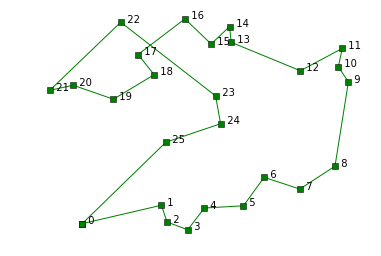

In [13]:
c26 = two_opt(26)

labeled_plot(c26)

Interesting... there is an intersection at lines $\overline{16-17}$ and $\overline{22-23}$, but our 2-Opt algorithm did not correct this issue. Let's see if we can figure out why by manually emulating the switch we would have expected.

In [14]:
c26[17], c26[22] = c26[22], c26[17]

('Route distance:', 2241.0330397892594)


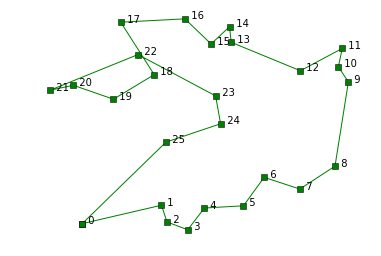

In [15]:
labeled_plot(c26)

Ah! It looks like the uncrossed solution actually results in a route that is longer than the original - a condition we set for our algorithm to prevent it from chasing segment swaps that would result in less optimal solutions. This solution would have failed that condition.

One alteration we might want to consider for a future implementation is allowing our algorithm to make a switch to a less optimal state if that switch eventually results in a better solution. Let's continue optimizing this route by uncrossing and see where we end up.

In [16]:
c26[18], c26[22] = c26[22], c26[18]

('Route distance:', 2178.870443898185)


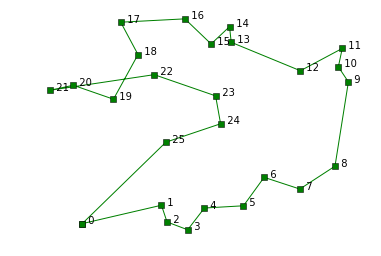

In [17]:
labeled_plot(c26)

In [18]:
c26[21], c26[20] = c26[20], c26[21]

('Route distance:', 2174.925871704265)


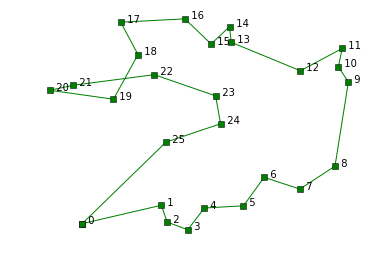

In [19]:
labeled_plot(c26)

In [20]:
c26[19], c26[21] = c26[21], c26[19]

('Route distance:', 2150.9979609137963)


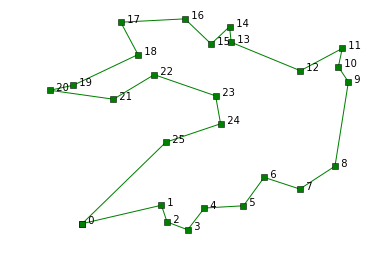

In [21]:
labeled_plot(c26)

In this case, it took 4 switches after our algorithm would have quit, but we were able to eventually find a more optimal solution with a ~3.5% shorter route length. That may end up being too small of an improvement to justify the added calculating expense, but it may be worth exploring.

In [22]:
def two_opt(n, t=10,seed=1000):
    """Creates a set of cities and finds a solution to TSP by first using
    a greedy algorithm. Then identifies if there are any crossed lines in
    the solution set. If there are, it removes those lines from the
    solution and attempts to replace them with non-crossed lines."""
    cities = make_cities(n)
    attempts = 0
    while crossed(cities):
        new_cities = uncross(cities)
        if new_cities == cities:
            attempts += 1
        else: attempts = 0
        cities = new_cities
        if attempts >= t: break
    return cities